In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchviz import make_dot
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error

In [19]:
class CNN_BiLSTM_MultiheadAttention(nn.Module):
    def __init__(self, input_size=4, window=5, lstm_units=16, num_heads=4, dropout_rate=0.1):
        super(CNN_BiLSTM_MultiheadAttention, self).__init__()
        
        # 1D Convolutional Layer
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=lstm_units, kernel_size=1)
        
        # MaxPooling Layer
        self.pool = nn.MaxPool1d(kernel_size=window)
        
        # Bidirectional LSTM Layer
        self.bilstm = nn.LSTM(input_size=lstm_units, hidden_size=lstm_units, num_layers=1, 
                              batch_first=True, bidirectional=True)
        
        # Multi-head Attention Layer
        # self.attention = nn.Linear(lstm_units * 2, lstm_units * 2)
        self.attention = nn.MultiheadAttention(embed_dim=lstm_units * 2, num_heads=num_heads, batch_first=True)
        
        # Dropout Layer
        self.dropout = nn.Dropout(dropout_rate)
        
        # Output Layer
        self.fc = nn.Linear(lstm_units * 2, 1)

    def forward(self, x):
        # CNN Layer
        x = x.permute(0, 2, 1)  # (batch, features, seq_len) for Conv1d
        x = torch.sigmoid(self.conv1d(x))
        x = self.pool(x)  # Pooling over the time dimension
        x = self.dropout(x)
        
        # Reshape for LSTM
        x = x.permute(0, 2, 1)  # (batch, seq_len, features) for LSTM
        
        # BiLSTM Layer
        lstm_out, _ = self.bilstm(x)  # (batch, seq_len, lstm_units*2)
        
        # Multi-Head Attention Layer
        # attn_weights = torch.sigmoid(self.attention(lstm_out))
        # attn_output = attn_weights * lstm_out
        attn_output, _ = self.attention(lstm_out, lstm_out, lstm_out)

        
        # Fully Connected Layer (Output)
        output = torch.tanh(self.fc(attn_output[:, -1, :]))  # Use the last time step
        return output

# Model Parameters
input_size = 4  # Placeholder (should match the number of features in the data)
window = 5
lstm_units = 16
num_heads = 4   # Number of attention heads
dropout_rate = 0.01

# Instantiate the Model
model = CNN_BiLSTM_MultiheadAttention(input_size, window, lstm_units, num_heads, dropout_rate)

# Display Model Summary
print(model)

CNN_BiLSTM_MultiheadAttention(
  (conv1d): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(16, 16, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.01, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# Data Preparation

In [3]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def data_preprocess(fname: str, window: int):
    # Read data & ensure time series property
    df = pd.read_csv(fname)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Use only numerical features for time series modeling
    numeric_features = ['Open', 'Low', 'Close', 'High']

    # Normalize the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[numeric_features])

    # Predict the next day's close price
    prediction_horizon = 1
   
    # Create sequences
    sequences = []
    targets = []
    sequence_dates = []
    for i in range(len(scaled_data) - window - prediction_horizon + 1):
        seq = scaled_data[i:i+window]
        target = scaled_data[i+window:i+window+prediction_horizon,2]
        sequences.append(seq)
        targets.append(target)
        sequence_dates.append(df['Date'].iloc[i + window])
    
    X, y = np.array(sequences), np.array(targets)
    dates = np.array(sequence_dates)

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    train_dates, test_dates = dates[:train_size], dates[train_size:]

    print([len(train_dataset), len(test_dataset), X_train.shape, X_test.shape, y_train.shape, y_test.shape])
    return train_dataset, test_dataset, test_dates

# Model Training

In [4]:
def train_model(model, train_dataset, test_dataset, num_epochs, batch_size, learning_rate):
    # optimizer for regression like task
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training Loop
    train_losses = []
    test_losses = []
    best_test_mse = float('inf')  # Track the lowest test loss
    best_model_state = None  # Store best model parameters
    best_epoc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward Pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)

        # Calculate Average Loss
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Evaluate on Test Set
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        test_mse = mean_squared_error(y_batch.cpu().numpy(), outputs.cpu().numpy())

        if test_mse < best_test_mse:
            best_test_mse = test_mse
            best_model_state = model.state_dict()
            best_epoc = epoch + 1

        # Display Progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
    
    # Restore the best model parameters
    model.load_state_dict(best_model_state)
    print(f'Best Test MSE: {best_test_mse:.6f} at Epoc {best_epoc} - Restoring Best Model Parameters.')

    # Save the best model to a file
    torch.save(best_model_state, 'best_model.pth')

    # Plot Training and Test Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Model Evaluation

In [17]:
def test_model(model: nn.Module, test_dataset: Dataset, test_dates):
    model.eval()
    predictions = []
    actuals = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).squeeze().cpu().numpy()
            predictions.extend(outputs)
            actuals.extend(y_batch.squeeze().numpy())

    # Convert to numpy arrays for plotting
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate Metrics
    mape = mean_absolute_percentage_error(actuals, predictions)
    rmse = np.sqrt(root_mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    print(f'Mean Absolute Percentage Error: {mape:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'R^2 Score: {r2:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, actuals, label='Actual Close Price', alpha=0.7, linewidth=2)
    plt.plot(test_dates, predictions, label='Predicted Close Price', alpha=0.7, linewidth=2, linestyle='--')
    plt.title('Test Set Predictions vs. Actual Close Price')
    plt.xlabel('Date')
    plt.ylabel('Close Price (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fit on USD/CNY Exchange Rate (USDCNY.IB) Data 

[21017, 5255, (21017, 5, 4), (5255, 5, 4), (21017, 1), (5255, 1)]
Epoch [5/60], Train Loss: 0.037445, Test Loss: 0.087771
Epoch [10/60], Train Loss: 0.004890, Test Loss: 0.023792
Epoch [15/60], Train Loss: 0.002722, Test Loss: 0.006494
Epoch [20/60], Train Loss: 0.002523, Test Loss: 0.003701
Epoch [25/60], Train Loss: 0.002454, Test Loss: 0.002397
Epoch [30/60], Train Loss: 0.002193, Test Loss: 0.001538
Epoch [35/60], Train Loss: 0.002049, Test Loss: 0.000944
Epoch [40/60], Train Loss: 0.001811, Test Loss: 0.000565
Epoch [45/60], Train Loss: 0.001511, Test Loss: 0.000228
Epoch [50/60], Train Loss: 0.001243, Test Loss: 0.000113
Epoch [55/60], Train Loss: 0.001026, Test Loss: 0.000140
Epoch [60/60], Train Loss: 0.000900, Test Loss: 0.000148
Best Test MSE: 0.000002 at Epoc 55 - Restoring Best Model Parameters.


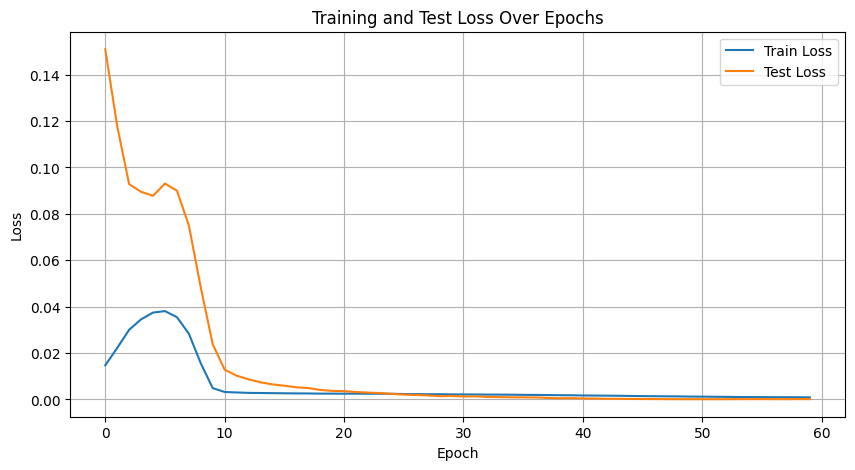

Mean Absolute Percentage Error: 0.0146
Root Mean Squared Error: 0.1103
R^2 Score: 0.9578


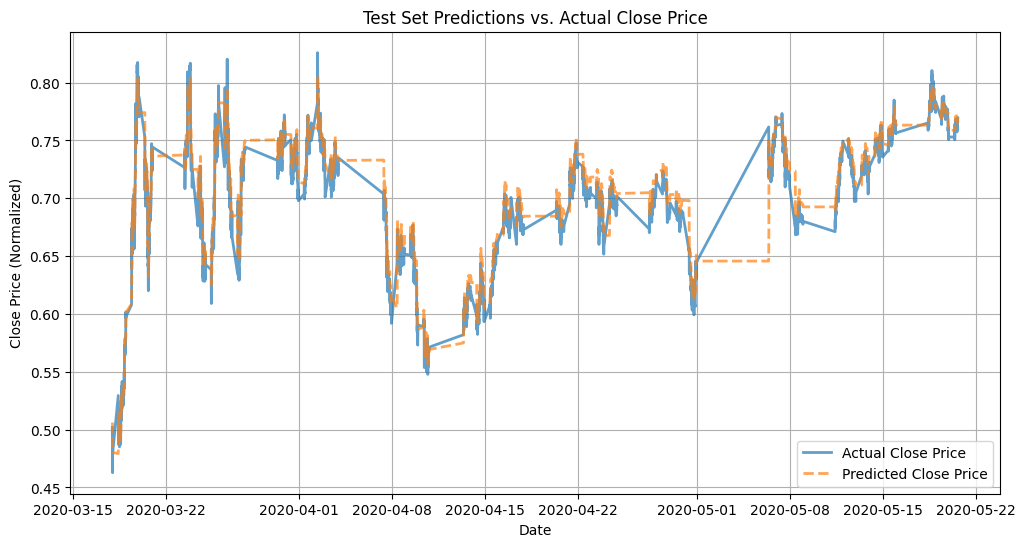

In [6]:
train_dataset, test_dataset, test_dates = data_preprocess('data.csv', 5)
train_model(model, train_dataset, test_dataset, 60, 64, 0.001)
test_model(model, test_dataset, test_dates)

# Train on TSLA Data

[2420, 605, (2420, 5, 4), (605, 5, 4), (2420, 1), (605, 1)]
Epoch [5/100], Train Loss: 0.000196, Test Loss: 0.021872
Epoch [10/100], Train Loss: 0.000178, Test Loss: 0.135467
Epoch [15/100], Train Loss: 0.000164, Test Loss: 0.270557
Epoch [20/100], Train Loss: 0.000161, Test Loss: 0.301159
Epoch [25/100], Train Loss: 0.000151, Test Loss: 0.276711
Epoch [30/100], Train Loss: 0.000160, Test Loss: 0.260181
Epoch [35/100], Train Loss: 0.000140, Test Loss: 0.228151
Epoch [40/100], Train Loss: 0.000130, Test Loss: 0.182413
Epoch [45/100], Train Loss: 0.000138, Test Loss: 0.133206
Epoch [50/100], Train Loss: 0.000134, Test Loss: 0.106146
Epoch [55/100], Train Loss: 0.000119, Test Loss: 0.058454
Epoch [60/100], Train Loss: 0.000121, Test Loss: 0.034926
Epoch [65/100], Train Loss: 0.000124, Test Loss: 0.019906
Epoch [70/100], Train Loss: 0.000107, Test Loss: 0.012171
Epoch [75/100], Train Loss: 0.000102, Test Loss: 0.010979
Epoch [80/100], Train Loss: 0.000092, Test Loss: 0.014370
Epoch [85/100

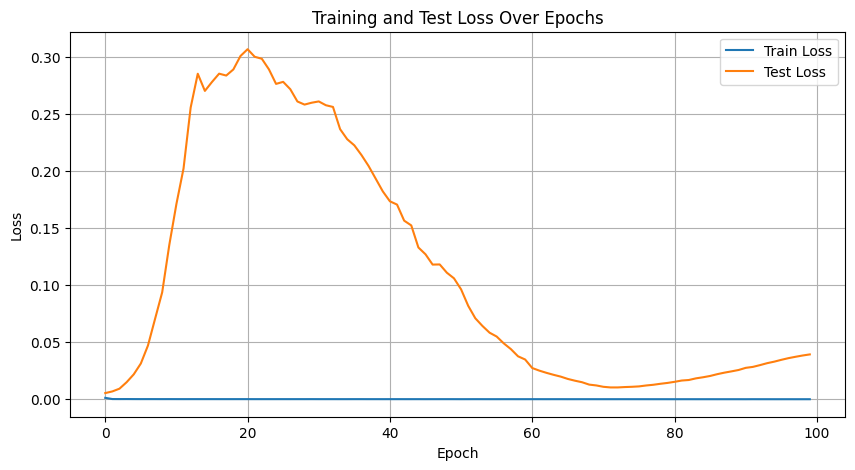

Mean Absolute Percentage Error: 0.3315
Root Mean Squared Error: 0.4455
R^2 Score: 0.2905


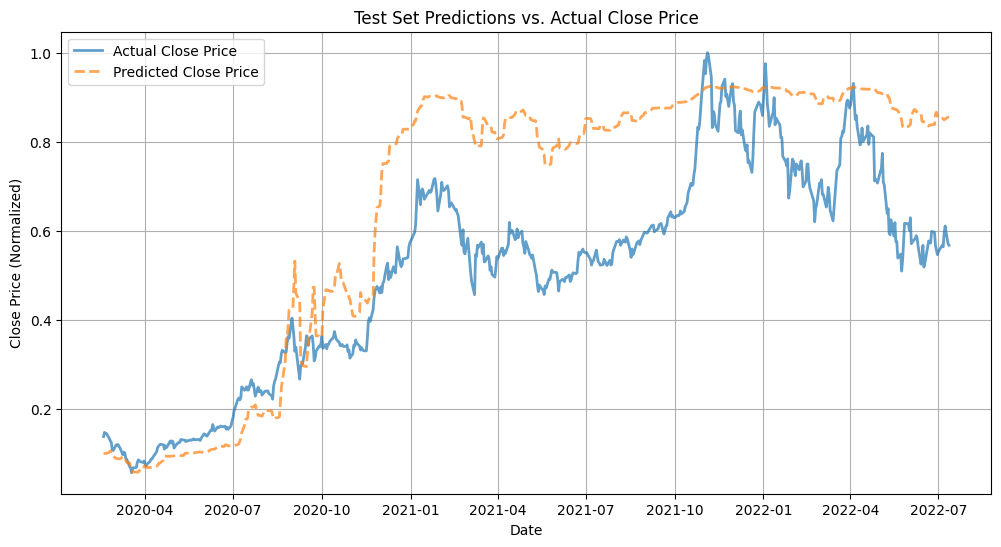

In [7]:
train_dataset, test_dataset, test_dates = data_preprocess('TSLA.csv', 5)
train_model(model, train_dataset, test_dataset, 100, 32, 0.0008)
test_model(model, test_dataset, test_dates)

# Train on Ford Data

In [ ]:
train_dataset, test_dataset, test_dates = data_preprocess('F.csv', 5)
train_model(model, train_dataset, test_dataset, 100, 32, 0.0008)
test_model(model, test_dataset, test_dates)

# Model Visualization

In [ ]:

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
X_batch, y_batch = test_loader.dataset[0][0], test_loader.dataset[0][1]
output = model(X_batch.unsqueeze(0))
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render('model', cleanup=True, format='svg')

# Load Saved Best Tesla Model For Reproducibility

[2420, 605, (2420, 5, 4), (605, 5, 4), (2420, 1), (605, 1)]
Mean Absolute Percentage Error: 0.1502
Root Mean Squared Error: 0.2797
R^2 Score: 0.8897


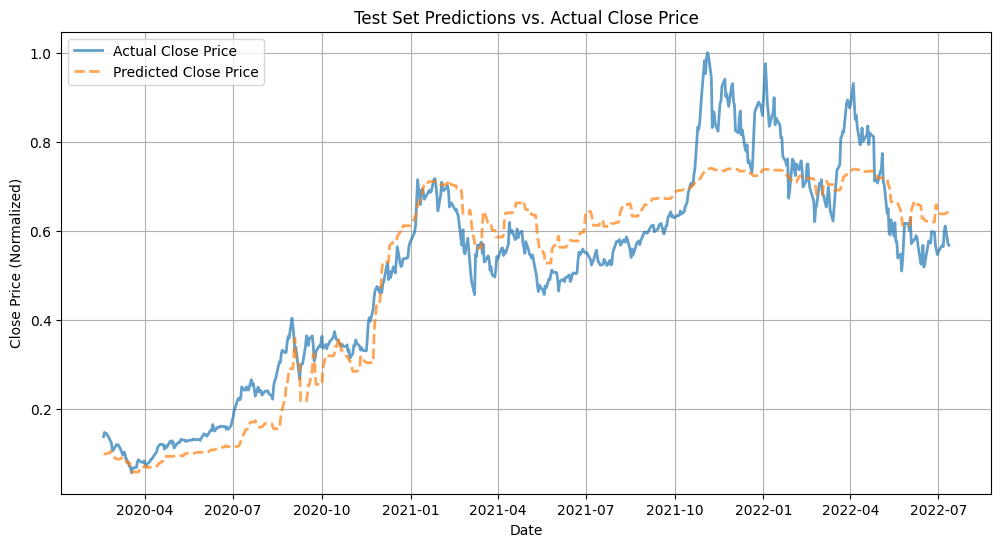

In [22]:
model = CNN_BiLSTM_MultiheadAttention()
model.load_state_dict(torch.load('best_model_tsla.pth'))
train_dataset, test_dataset, test_dates = data_preprocess('TSLA.csv', 5)
test_model(model, test_dataset, test_dates)